In [2]:
# Importing Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, SGDRegressor, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_absolute_error


## Loading the Data and Early Data Inspection

In [3]:
df = pd.read_csv('train_data.csv')
df.head()

,UserID,QuestionTiming,TimeUtc,CurrentGameMode,CurrentTask,CurrentSessionLength,LastTaskCompleted,LevelProgressionAmount,QuestionType,ResponseValue
0,p1,User Initiated,2022-08-18 22:55:27,NaN,NaN,2,NaN,NaN,Wellbeing,509.0
1,p1,System Initiated,2022-08-18 23:38:31,NaN,NaN,0,NaN,NaN,Wellbeing,653.0
2,p1,User Initiated,2022-08-18 23:39:24,Career,HOME_VAN,1,WASH_PWVan,1.000000,Wellbeing,705.0
3,p1,System Initiated,2022-08-18 23:45:01,Career,RESIDENTIALSMALL_BACKYARD,6,WASH_PWVan,0.168267,Wellbeing,817.0
4,p1,System Initiated,2022-08-18 23:51:22,Career,RESIDENTIALSMALL_BACKYARD,13,WASH_PWVan,0.429364,Wellbeing,810.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134420 entries, 0 to 134419
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   UserID                  134420 non-null  object 
 1   QuestionTiming          134420 non-null  object 
 2   TimeUtc                 134420 non-null  object 
 3   CurrentGameMode         117407 non-null  object 
 4   CurrentTask             117407 non-null  object 
 5   CurrentSessionLength    134420 non-null  int64  
 6   LastTaskCompleted       71815 non-null   object 
 7   LevelProgressionAmount  117402 non-null  float64
 8   QuestionType            134420 non-null  object 
 9   ResponseValue           134420 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 10.3+ MB


In [5]:
test_df = pd.read_csv('test_data.csv')

In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60832 entries, 0 to 60831
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UserID                  60832 non-null  object 
 1   QuestionTiming          60832 non-null  object 
 2   TimeUtc                 60832 non-null  object 
 3   CurrentGameMode         50499 non-null  object 
 4   CurrentTask             50499 non-null  object 
 5   CurrentSessionLength    60832 non-null  int64  
 6   LastTaskCompleted       24031 non-null  object 
 7   LevelProgressionAmount  50497 non-null  float64
 8   QuestionType            60832 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 4.2+ MB


## Exploratory Data Analysis

### Missing Values

In [7]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values

CurrentGameMode           17013
CurrentTask               17013
LastTaskCompleted         62605
LevelProgressionAmount    17018
dtype: int64

In [8]:
# calculating the percentage of missing values
missing_values_per = df.isnull().sum()*100/len(df)
print(missing_values_per)

UserID                     0.000000
QuestionTiming             0.000000
TimeUtc                    0.000000
CurrentGameMode           12.656599
CurrentTask               12.656599
CurrentSessionLength       0.000000
LastTaskCompleted         46.574171
LevelProgressionAmount    12.660318
QuestionType               0.000000
ResponseValue              0.000000
dtype: float64


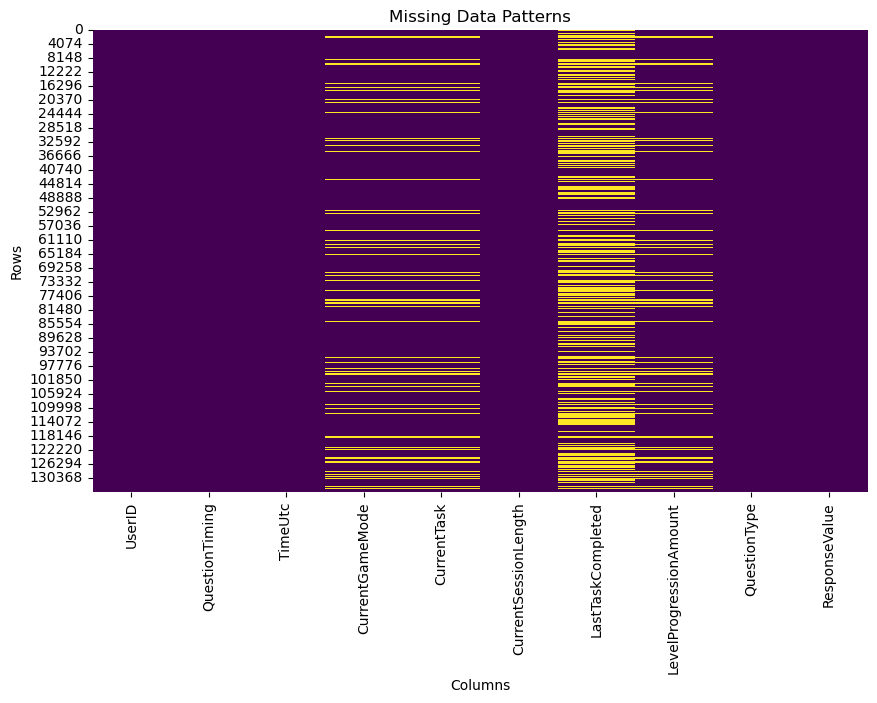

In [9]:
# missing data patterns
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Patterns')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

In [10]:
# Filling missing values
df["CurrentGameMode"] = df["CurrentGameMode"].fillna("None")
df["CurrentTask"] = df["CurrentTask"].fillna("None")
df["LastTaskCompleted"] = df["LastTaskCompleted"].fillna("None")
df["LevelProgressionAmount"] = df["LevelProgressionAmount"].fillna(0)

In [11]:
# checking for duplicates
df.duplicated().sum()

0

### Histograms of Numerical Features

Text(0, 0.5, 'Density')

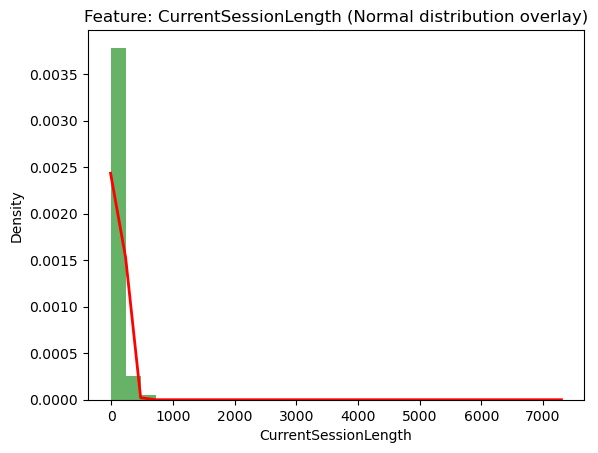

In [12]:
column = 'CurrentSessionLength'

mu, sigma = df[column].mean(), df[column].std()

fig, ax = plt.subplots()
count, bins, ignored = ax.hist(df[column], 30, density=True, alpha=0.6, color='g')

ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(bins - mu)**2 / (2 * sigma**2)), linewidth=2, color='r')

ax.set_title(f'Feature: {column} (Normal distribution overlay)')
ax.set_xlabel(column)
ax.set_ylabel('Density')

Text(0, 0.5, 'Density')

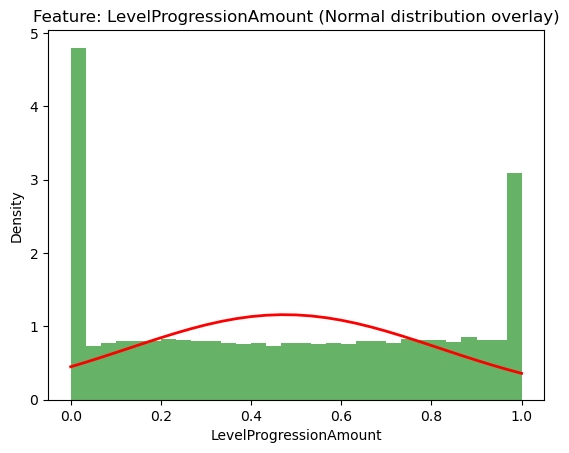

In [13]:
column = 'LevelProgressionAmount'

mu, sigma = df[column].mean(), df[column].std()

fig, ax = plt.subplots()
count, bins, ignored = ax.hist(df[column], 30, density=True, alpha=0.6, color='g')

ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(bins - mu)**2 / (2 * sigma**2)), linewidth=2, color='r')

ax.set_title(f'Feature: {column} (Normal distribution overlay)')
ax.set_xlabel(column)
ax.set_ylabel('Density')

### Boxplot of Numerical Features

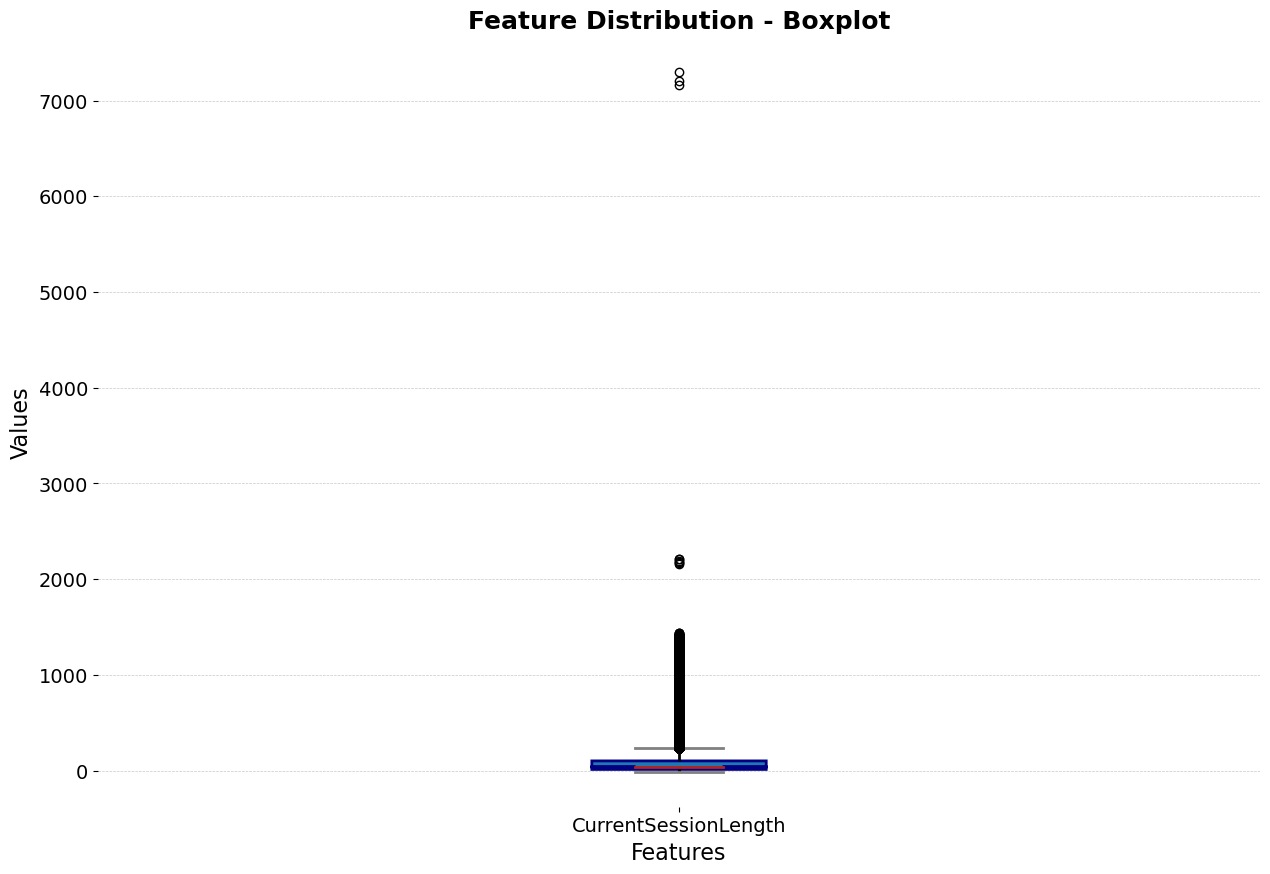

In [14]:
plt.figure(figsize=(15, 10))

# Create the boxplot with additional styling
boxprops = dict(linestyle='-', linewidth=2, color='navy')
medianprops = dict(linestyle='-', linewidth=2, color='firebrick')
whiskerprops = dict(linestyle='--', linewidth=2, color='black')
capprops = dict(linestyle='-', linewidth=2, color='grey')

boxplot = plt.boxplot(df['CurrentSessionLength'], labels=['CurrentSessionLength'],
                      notch=True, patch_artist=True, 
                      boxprops=boxprops, medianprops=medianprops, 
                      whiskerprops=whiskerprops, capprops=capprops)

# Adding grid, title and labels
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, axis='y')
plt.title('Feature Distribution - Boxplot', fontsize=18, fontweight='bold')
plt.xlabel('Features', fontsize=16)
plt.ylabel('Values', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Remove spines
for spine in plt.gca().spines.values():
    spine.set_visible(False)

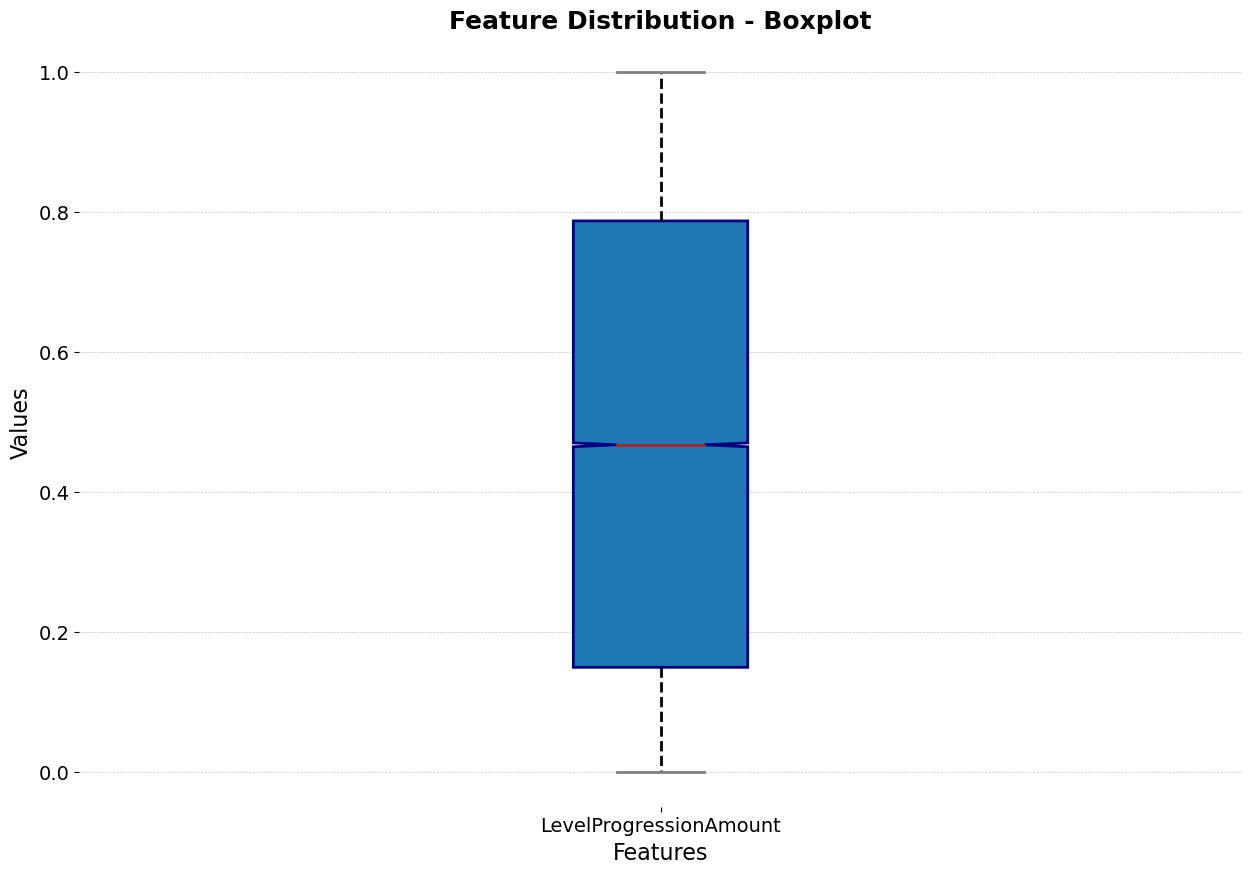

In [15]:

# Enhanced Box plots
plt.figure(figsize=(15, 10))

# Create the boxplot with additional styling
boxprops = dict(linestyle='-', linewidth=2, color='navy')
medianprops = dict(linestyle='-', linewidth=2, color='firebrick')
whiskerprops = dict(linestyle='--', linewidth=2, color='black')
capprops = dict(linestyle='-', linewidth=2, color='grey')

boxplot = plt.boxplot(df['LevelProgressionAmount'], labels=['LevelProgressionAmount'],
                      notch=True, patch_artist=True, 
                      boxprops=boxprops, medianprops=medianprops, 
                      whiskerprops=whiskerprops, capprops=capprops)

# Adding grid, title and labels
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, axis='y')
plt.title('Feature Distribution - Boxplot', fontsize=18, fontweight='bold')
plt.xlabel('Features', fontsize=16)
plt.ylabel('Values', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Remove spines
for spine in plt.gca().spines.values():
    spine.set_visible(False)


### Outiliers

In [16]:
df['CurrentSessionLength'].describe()

count    134420.000000
mean         80.978671
std         125.130636
min         -11.000000
25%          13.000000
50%          39.000000
75%         102.000000
max        7301.000000
Name: CurrentSessionLength, dtype: float64

In [17]:
CurrentSessionLength_minus = df['CurrentSessionLength'][df['CurrentSessionLength'] < 0]
CurrentSessionLength_minus

49910   -11
Name: CurrentSessionLength, dtype: int64

In [18]:
test_df['CurrentSessionLength'].describe()

count    60832.000000
mean        81.838818
std        130.806339
min          0.000000
25%         10.000000
50%         36.000000
75%        101.000000
max       4206.000000
Name: CurrentSessionLength, dtype: float64

In [19]:
# set the values in 'CurrentSessionLength' column that are less than 0 to 0
df.loc[df['CurrentSessionLength'] < 0, 'CurrentSessionLength'] = 0

# Feature Engineering

## 1. boolean - QuestionTiming

In [20]:
print(df['QuestionTiming'].unique())

['User Initiated' 'System Initiated']


In [21]:
df['QuestionTiming'] = df['QuestionTiming'].map({'System Initiated': True, 'User Initiated': False})

## 2.categorical 

In [22]:
df.UserID = pd.Categorical(df.UserID)
df.CurrentGameMode = pd.Categorical(df.CurrentGameMode)
df.CurrentTask = pd.Categorical(df.CurrentTask)
df.LastTaskCompleted = pd.Categorical(df.LastTaskCompleted)
df.QuestionType = pd.Categorical(df.QuestionType)

## 3.datetime

In [23]:

df['TimeUtc'] = pd.to_datetime(df['TimeUtc'], errors='coerce')

# Extract components from the datetime
df['month'] = df['TimeUtc'].dt.month
df['day_of_week'] = df['TimeUtc'].dt.dayofweek  # Monday=0, Sunday=6
df['week_of_year'] = df['TimeUtc'].dt.isocalendar().week
df['is_weekend'] = df['TimeUtc'].dt.dayofweek >= 5
df['hour'] = df['TimeUtc'].dt.hour

In [24]:
df.count(axis=0)

UserID                    134420
QuestionTiming            134420
TimeUtc                   134420
CurrentGameMode           134420
CurrentTask               134420
CurrentSessionLength      134420
LastTaskCompleted         134420
LevelProgressionAmount    134420
QuestionType              134420
ResponseValue             134420
month                     134420
day_of_week               134420
week_of_year              134420
is_weekend                134420
hour                      134420
dtype: int64

## 4.drop features

In [25]:
print(df['QuestionType'].unique())

['Wellbeing']
Categories (1, object): ['Wellbeing']


In [26]:
df = df.drop(columns=['QuestionType'])

In [27]:
numerical_features = ['CurrentSessionLength', 'LevelProgressionAmount','hour', 'day_of_week', 'month', 'week_of_year']
categorical_features = ['UserID','CurrentGameMode', 'CurrentTask', 'LastTaskCompleted']
boolean_features = ['is_weekend', 'QuestionTiming']
features = numerical_features + categorical_features + boolean_features
target = 'ResponseValue'

### Feature Correlations 

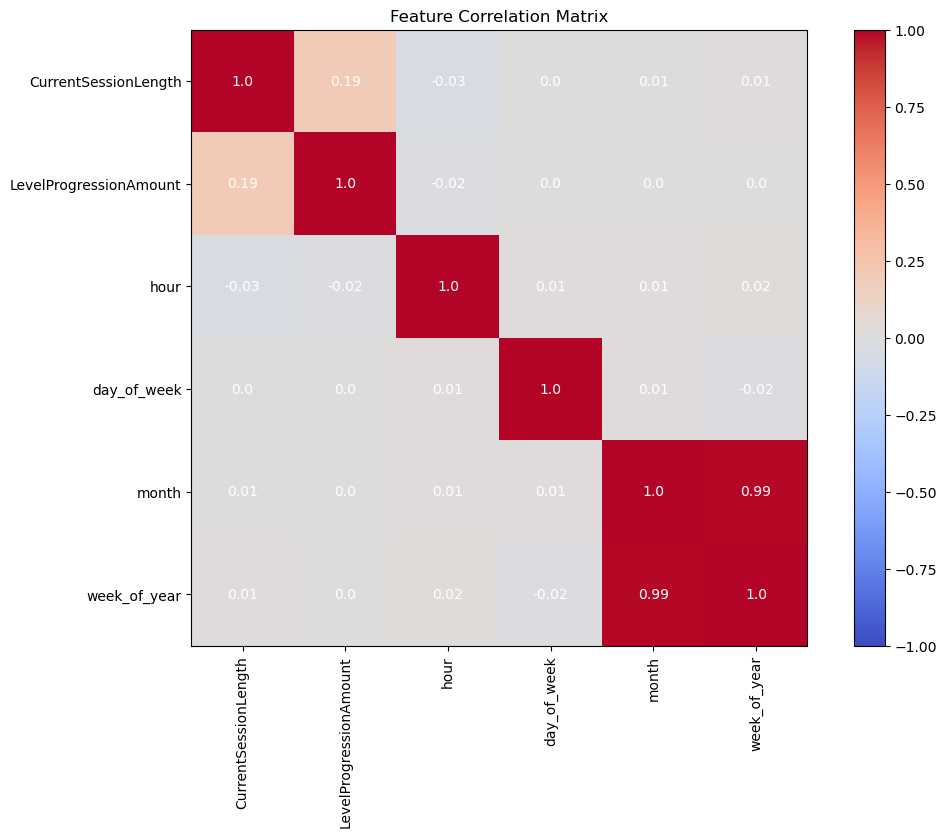

In [28]:
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(12, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', vmax=1, vmin=-1)
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Feature Correlation Matrix')
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        text = plt.text(j, i, np.around(correlation_matrix.iloc[i, j], decimals=2),
                        ha="center", va="center", color="w")

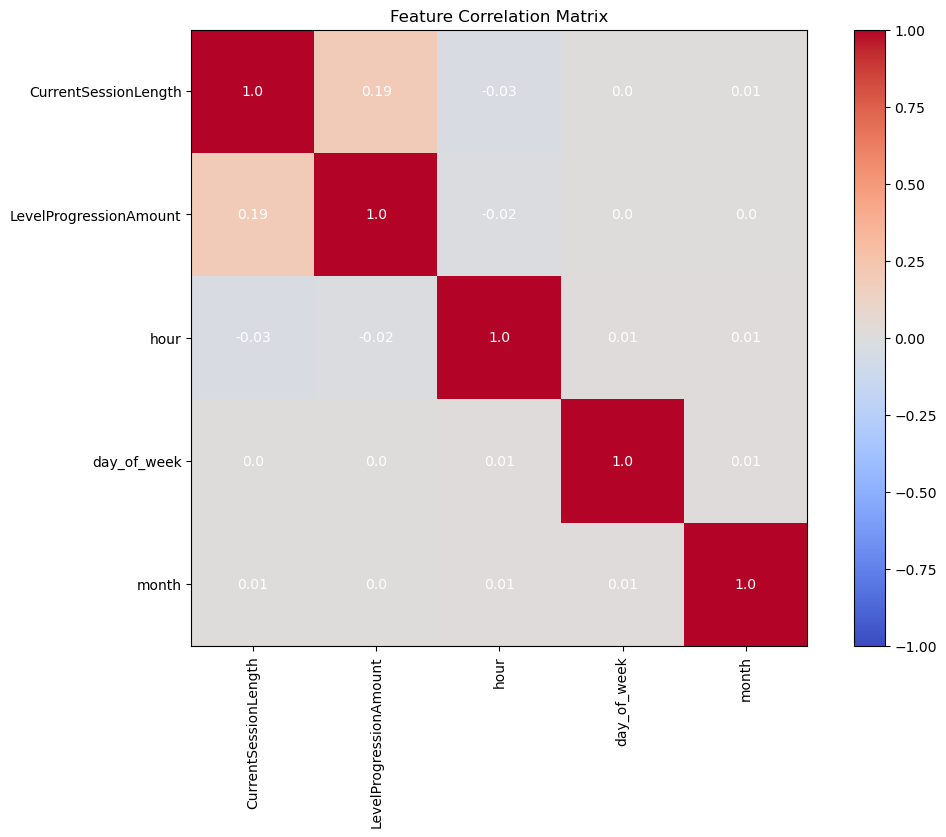

In [29]:
#drop week_of_year from numerical features
numerical_features = ['CurrentSessionLength', 'LevelProgressionAmount','hour', 'day_of_week', 'month']

correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(12, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', vmax=1, vmin=-1)
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Feature Correlation Matrix')
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        text = plt.text(j, i, np.around(correlation_matrix.iloc[i, j], decimals=2),
                        ha="center", va="center", color="w")

### save data

In [30]:
X = df[features]
y = df[target]
X.to_csv('preprocessed_features.csv', sep=',', index=False) # Saving a Pandas dataframe in a CSV file
np.savetxt('preprocessed_targets.csv', y, delimiter=',', fmt='%d') # Saving a numpy array in a CSV file

In [31]:
X.head()

,CurrentSessionLength,LevelProgressionAmount,hour,day_of_week,month,week_of_year,UserID,CurrentGameMode,CurrentTask,LastTaskCompleted,is_weekend,QuestionTiming
0,2,0.000000,22,3,8,33,p1,None,None,None,False,False
1,0,0.000000,23,3,8,33,p1,None,None,None,False,True
2,1,1.000000,23,3,8,33,p1,Career,HOME_VAN,WASH_PWVan,False,False
3,6,0.168267,23,3,8,33,p1,Career,RESIDENTIALSMALL_BACKYARD,WASH_PWVan,False,True
4,13,0.429364,23,3,8,33,p1,Career,RESIDENTIALSMALL_BACKYARD,WASH_PWVan,False,True


# Model Selection and Hyperparameters

In [32]:
#split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Define preprocessing for numerical and categorical features

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('bool', 'passthrough', boolean_features)
    ])

## XGB

In [34]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
# Create the pipeline with an XGBoost Regressor
xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')

xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', xgb_model)])

# Train the model
xgb_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_pipeline.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")


Mean Absolute Error (MAE): 154.7129022439061


## Gradient Descent

In [35]:

# Create the pipeline with an SGDRegressor
sgd_model = SGDRegressor(random_state=42, max_iter=5000)

sgd_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', sgd_model)])

# Train the model
sgd_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = sgd_pipeline.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 114.7317180076273


In [42]:

# Apply cross-validation
cv_scores = cross_val_score(sgd_pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')  # 5-fold cross-validation

# Print cross-validation results
print("Cross-Validation MAE Scores:", -cv_scores)
print("Mean Cross-Validation MAE:", -cv_scores.mean())


Cross-Validation MAE Scores: [169.26223896 171.16350238 171.53564611 170.36657141 175.02292988]
Mean Cross-Validation MAE: 171.47017774866694


In [46]:


# Define the parameter grid for SGDRegressor
param_grid = {
    'model__alpha': [1e-4, 1e-3, 1e-2],  # Regularization term
    'model__max_iter': [1000, 2000, 3000, 4000, 5000],  # Number of iterations
    'model__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],  # Learning rate schedule
    'model__eta0': [0.01, 0.05, 0.1]  # Initial learning rate
}

# Set up the GridSearchCV
grid_search = GridSearchCV(sgd_pipeline, param_grid, 
                           scoring='neg_mean_absolute_error', 
                           cv=3, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best MAE found: ", best_score)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict and evaluate
y_pred_best = best_model.predict(X_val)
mae_best = mean_absolute_error(y_val, y_pred_best)

print(f"Mean Absolute Error (MAE) with best model: {mae_best}")

Fitting 3 folds for each of 180 candidates, totalling 540 fits


/Users/sunmingyue/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/sunmingyue/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/sunmingyue/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/sunmingyue/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Best parameters found:  {'model__alpha': 0.0001, 'model__eta0': 0.1, 'model__learning_rate': 'adaptive', 'model__max_iter': 1000}
Best MAE found:  114.68868023382454
Mean Absolute Error (MAE) with best model: 113.38254373524174


## Linear Regression

In [36]:
# Create pipeline
pipeline_LR = Pipeline(steps=[('preprocessor', preprocessor), ('model', LinearRegression())])

# Fit the pipeline on the training data
pipeline_LR.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline_LR.predict(X_val)

# Evaluate the model
test_mae = mean_absolute_error(y_val, y_pred)
print("Test MAE:", test_mae)

Test MAE: 96.48187341370702


In [51]:
# Define parameter grid for GridSearchCV
param_grid = {
    'model__fit_intercept': [True, False],
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=pipeline_LR, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best MAE: ", -grid_search.best_score_)

Best parameters found:  {'model__fit_intercept': False}
Best cross-validation MAE:  98.40997580213578


In [37]:
# Create pipeline
pipeline_LR_Best = Pipeline(steps=[('preprocessor', preprocessor), ('model', LinearRegression(fit_intercept=False))])
# Fit the pipeline on the training data
pipeline_LR_Best.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline_LR_Best.predict(X_val)

# Evaluate the model
test_mae = mean_absolute_error(y_val, y_pred)
print("Test MAE:", test_mae)

Test MAE: 96.48167803964297


# prediction on test data

using the best model Linear Regression to predict targets values of test data

In [38]:
# Custom transformer to map 'QuestionTiming'
def map_question_timing(df):
    df = df.copy()
    df['QuestionTiming'] = df['QuestionTiming'].map({'System Initiated': True, 'User Initiated': False})
    return df

# Custom transformer to fill missing values
def fill_missing_values(df):
    df = df.copy()
    df["CurrentGameMode"] = df["CurrentGameMode"].fillna("None")
    df["CurrentTask"] = df["CurrentTask"].fillna("None")
    df["LastTaskCompleted"] = df["LastTaskCompleted"].fillna("None")
    df["LevelProgressionAmount"] = df["LevelProgressionAmount"].fillna(0)
    return df

# Custom transformer to extract datetime features
def extract_datetime_features(df):
    df = df.copy()
    df['TimeUtc'] = pd.to_datetime(df['TimeUtc'], errors='coerce')
    df['month'] = df['TimeUtc'].dt.month
    df['day_of_week'] = df['TimeUtc'].dt.dayofweek  # Monday=0, Sunday=6
    df['is_weekend'] = df['TimeUtc'].dt.dayofweek >= 5
    df['hour'] = df['TimeUtc'].dt.hour
    return df

# Load data
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Define feature columns
numerical_features = ['CurrentSessionLength', 'LevelProgressionAmount', 'hour', 'day_of_week', 'month']
categorical_features = ['UserID', 'CurrentGameMode', 'CurrentTask', 'LastTaskCompleted']
boolean_features = ['is_weekend', 'QuestionTiming']

# Define the preprocessing steps
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Custom transformer for feature extraction
preprocessing_pipeline = Pipeline(steps=[
    ('map_question_timing', FunctionTransformer(map_question_timing)),
    ('fill_missing_values', FunctionTransformer(fill_missing_values)),
    ('extract_datetime_features', FunctionTransformer(extract_datetime_features)),
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features),
            ('bool', 'passthrough', boolean_features)
        ])
    )
])

# Create the full pipeline with the model
model_pipeline = Pipeline(steps=[('preprocessor', preprocessing_pipeline), ('model', LinearRegression())])

# Split the data into features and target
X_train = train_data.drop('ResponseValue', axis=1)
y_train = train_data['ResponseValue']

# Fit the model
model_pipeline.fit(X_train, y_train)

# Predict on test data
X_test = test_data.copy()  # Ensure we don't modify the original test data
test_predictions = model_pipeline.predict(X_test)

# Save predictions
np.savetxt("predicted.csv", test_predictions)